# Music Genre Classification: Model Development and Comparison

## 1. Introduction

This notebook aims to develop a robust machine learning model to classify music tracks into their respective genres using a comprehensive Spotify dataset. Building upon initial exploratory analysis and baseline modeling, we implement a series of enhancements to improve model performance, address class imbalance, explore alternative algorithms, and leverage advanced techniques. The final section compares the performance of all models to identify the most effective approach for genre classification

## 2. Import Libraries

We begin by importing the necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier

from catboost import CatBoostClassifier

from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Suppress Warnings for Clean Output
import warnings

warnings.filterwarnings("ignore")

# Set Plot Style
sns.set(style="whitegrid")

## 3. Load and Inspect the Data

Load the dataset and perform initial inspections to understand its structure and identify any data quality issues.

In [2]:
# Load the dataset
data = pd.read_csv("data/ClassicHit.csv")

# Display the first few rows
data.head()

,Track,Artist,Year,Duration,Time_Signature,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Popularity,Genre
0,Hey Jack Kerouac,"10,000 Maniacs",1987,206413,4,0.616,0.511,6,-15.894,1,0.0279,0.03840,0.000000,0.1500,0.604,132.015,40,Alt. Rock
1,Like the Weather,"10,000 Maniacs",1987,236653,4,0.770,0.459,1,-17.453,1,0.0416,0.11200,0.003430,0.1450,0.963,133.351,43,Alt. Rock
2,What's the Matter Here?,"10,000 Maniacs",1987,291173,4,0.593,0.816,9,-7.293,1,0.0410,0.00449,0.000032,0.0896,0.519,99.978,12,Alt. Rock
3,Trouble Me,"10,000 Maniacs",1989,193560,4,0.861,0.385,2,-10.057,1,0.0341,0.15400,0.000000,0.1230,0.494,117.913,47,Alt. Rock
4,Candy Everybody Wants,"10,000 Maniacs",1992,185960,4,0.622,0.876,10,-6.310,1,0.0305,0.01930,0.006840,0.0987,0.867,104.970,43,Alt. Rock


In [3]:
# Inspect the dataset structure
print(data.info())

# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())

# Check for duplicate entries based on Artist and Track
duplicate_count = data.duplicated(subset=["Artist", "Track"]).sum()
print(f"\nNumber of duplicate entries based on Artist and Track: {duplicate_count}")

# Remove duplicate entries if any
data = data.drop_duplicates(subset=["Artist", "Track"])

# Verify removal
print(f"Dataset shape after removing duplicates: {data.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             15150 non-null  object 
 1   Artist            15150 non-null  object 
 2   Year              15150 non-null  int64  
 3   Duration          15150 non-null  int64  
 4   Time_Signature    15150 non-null  int64  
 5   Danceability      15150 non-null  float64
 6   Energy            15150 non-null  float64
 7   Key               15150 non-null  int64  
 8   Loudness          15150 non-null  float64
 9   Mode              15150 non-null  int64  
 10  Speechiness       15150 non-null  float64
 11  Acousticness      15150 non-null  float64
 12  Instrumentalness  15150 non-null  float64
 13  Liveness          15150 non-null  float64
 14  Valence           15150 non-null  float64
 15  Tempo             15150 non-null  float64
 16  Popularity        15150 non-null  int64 

## 4. Data Encoding and Feature Selection

Encode the target variable and select relevant features for modeling.

In [4]:
genre_encoder = LabelEncoder()
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()
time_signature_encoder = LabelEncoder()

# Encode the target variable 'Genre'
data["Genre_encoded"] = genre_encoder.fit_transform(data["Genre"])

# Encode the other categorical features
data["Key_encoded"] = key_encoder.fit_transform(data["Key"])
data["Mode_encoded"] = mode_encoder.fit_transform(data["Mode"])
data["Time_Signature_encoded"] = time_signature_encoder.fit_transform(
    data["Time_Signature"]
)

# Store mappings
genre_mapping = dict(
    zip(genre_encoder.classes_, genre_encoder.transform(genre_encoder.classes_))
)
key_mapping = dict(
    zip(key_encoder.classes_, key_encoder.transform(key_encoder.classes_))
)
mode_mapping = dict(
    zip(mode_encoder.classes_, mode_encoder.transform(mode_encoder.classes_))
)
time_signature_mapping = dict(
    zip(
        time_signature_encoder.classes_,
        time_signature_encoder.transform(time_signature_encoder.classes_),
    )
)

print("Genre Encoding Mapping:\n", genre_mapping)
print("Key Encoding Mapping:\n", key_mapping)
print("Mode Encoding Mapping:\n", mode_mapping)
print("Time Signature Encoding Mapping:\n", time_signature_mapping)

Genre Encoding Mapping:
 {'Alt. Rock': 0, 'Blues': 1, 'Country': 2, 'Disco': 3, 'EDM': 4, 'Folk': 5, 'Funk': 6, 'Gospel': 7, 'Jazz': 8, 'Metal': 9, 'Pop': 10, 'Punk': 11, 'R&B': 12, 'Rap': 13, 'Reggae': 14, 'Rock': 15, 'SKA': 16, 'Today': 17, 'World': 18}
Key Encoding Mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11}
Mode Encoding Mapping:
 {0: 0, 1: 1}
Time Signature Encoding Mapping:
 {0: 0, 1: 1, 3: 2, 4: 3, 5: 4}


In [5]:
# Select relevant features based on EDA
feature_columns = [
    "Duration",
    "Time_Signature_encoded",
    "Danceability",
    "Energy",
    "Key_encoded",
    "Mode_encoded",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
    "Valence",
    "Tempo",
] # Drop Loudness as it is highly correlated with Energy

X = data[feature_columns]
y = data["Genre_encoded"]

# Display feature statistics before scaling
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,14871.0,241037.917894,105988.468527,23000.000000,180026.0000,222533.000000,274699.50000,3060650.000
Time_Signature_encoded,14871.0,2.926770,0.307194,0.000000,3.0000,3.000000,3.00000,4.000
Danceability,14871.0,0.574312,0.166080,0.000000,0.4610,0.581000,0.69500,0.988
Energy,14871.0,0.616591,0.239827,0.000098,0.4400,0.642000,0.81800,0.999
Key_encoded,14871.0,5.252101,3.567939,0.000000,2.0000,5.000000,8.00000,11.000
Mode_encoded,14871.0,0.696994,0.459573,0.000000,0.0000,1.000000,1.00000,1.000
Speechiness,14871.0,0.075735,0.077812,0.000000,0.0343,0.046300,0.07815,0.950
Acousticness,14871.0,0.304231,0.318304,0.000001,0.0244,0.169000,0.56150,0.996
Instrumentalness,14871.0,0.091432,0.229720,0.000000,0.0000,0.000082,0.01250,0.987
Liveness,14871.0,0.200342,0.175741,0.012400,0.0919,0.130000,0.25700,0.996


## 5. Handling Class Imbalance

Address class imbalance using SMOTETomek to ensure the model learns equally from all genres.

In [6]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (11896, 12)
Testing set shape: (2975, 12)


In [7]:
# Apply SMOTETomek to the training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print(f"Training set shape after SMOTETomek: {X_train_resampled.shape}")
print(
    f"Class distribution after SMOTETomek:\n{pd.Series(y_train_resampled).value_counts()}"
)

Training set shape after SMOTETomek: (35078, 12)
Class distribution after SMOTETomek:
Genre_encoded
10    2348
15    1976
14    1932
11    1906
16    1901
17    1877
2     1875
12    1853
13    1850
1     1842
4     1838
0     1791
8     1790
9     1774
3     1736
5     1731
7     1721
18    1690
6     1647
Name: count, dtype: int64


## 6. Feature Multicollinearity, Scaling, and Transformation

Based on the EDA, apply log transformations to skewed features and standardize all features to ensure uniform scaling.

In [8]:
# Define a function for log transformation
def log_transform(series):
    return np.log1p(series - series.min() + 1)

In [9]:
# Features identified as skewed in EDA
features_to_transform = [
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
]

# Apply log transformation to skewed features in training and testing data
for feature in features_to_transform:
    if feature in X_train_resampled.columns:
        X_train_resampled[feature] = log_transform(X_train_resampled[feature])
        X_test[feature] = log_transform(X_test[feature])

In [10]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)

## 7. Baseline Model: DummyClassifier

Establish a baseline using a DummyClassifier to understand the minimum performance expectations.

In [11]:
# Initialize DummyClassifier with a stratified strategy
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

# Train the DummyClassifier
dummy_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_dummy = dummy_clf.predict(X_test_scaled)

# Evaluate the DummyClassifier
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
print(f"DummyClassifier Accuracy: {dummy_accuracy:.4f}")

# Display classification report
print("\nClassification Report for DummyClassifier:\n")
print(
    classification_report(y_test, y_pred_dummy, target_names=genre_encoder.classes_)
)

DummyClassifier Accuracy: 0.0635

Classification Report for DummyClassifier:

              precision    recall  f1-score   support

   Alt. Rock       0.06      0.06      0.06       156
       Blues       0.05      0.07      0.06       136
     Country       0.08      0.06      0.07       167
       Disco       0.08      0.08      0.08       130
         EDM       0.07      0.08      0.08       140
        Folk       0.04      0.05      0.05       112
        Funk       0.02      0.06      0.03        70
      Gospel       0.02      0.05      0.03        61
        Jazz       0.04      0.04      0.04       156
       Metal       0.06      0.06      0.06       177
         Pop       0.26      0.08      0.12       727
        Punk       0.06      0.06      0.06       149
         R&B       0.04      0.05      0.04       153
         Rap       0.06      0.07      0.06       144
      Reggae       0.02      0.03      0.02        87
        Rock       0.05      0.06      0.05       158
   

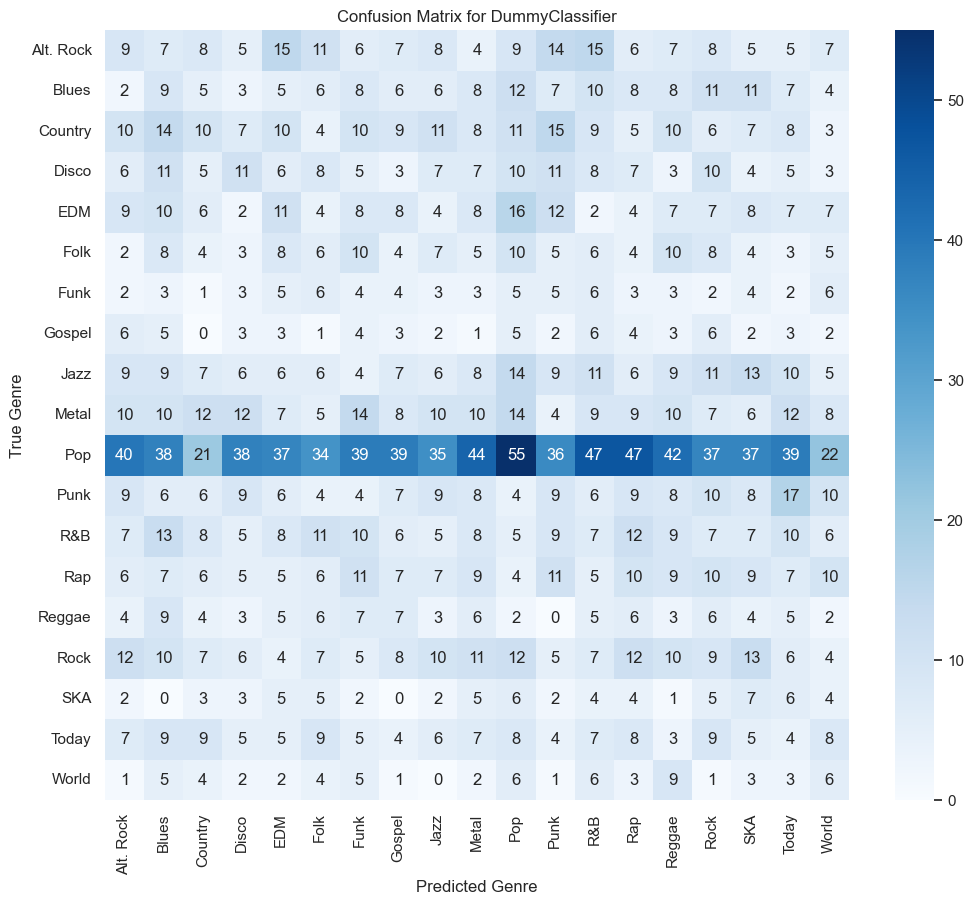

In [12]:
# Confusion Matrix for DummyClassifier

# Compute confusion matrix
conf_matrix_dummy = confusion_matrix(y_test, y_pred_dummy)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_dummy,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for DummyClassifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 8. Predictive Models

Train and evaluate multiple classifiers to benchmark against the baseline.

### a. Random Forest Classifier

In [13]:
# Initialize the Random Forest Classifier with class_weight='balanced'
rf_clf = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)

# Train the Random Forest model
rf_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Random Forest Classifier:\n")
print(
    classification_report(y_test, y_pred_rf, target_names=genre_encoder.classes_)
)

Random Forest Classifier Accuracy: 0.3630

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.18      0.22      0.20       156
       Blues       0.31      0.20      0.24       136
     Country       0.24      0.55      0.34       167
       Disco       0.37      0.36      0.37       130
         EDM       0.58      0.51      0.54       140
        Folk       0.23      0.16      0.19       112
        Funk       0.23      0.11      0.15        70
      Gospel       0.38      0.44      0.41        61
        Jazz       0.57      0.51      0.54       156
       Metal       0.50      0.48      0.49       177
         Pop       0.42      0.44      0.43       727
        Punk       0.53      0.50      0.51       149
         R&B       0.13      0.07      0.09       153
         Rap       0.54      0.59      0.56       144
      Reggae       0.32      0.38      0.35        87
        Rock       0.21      0.20      

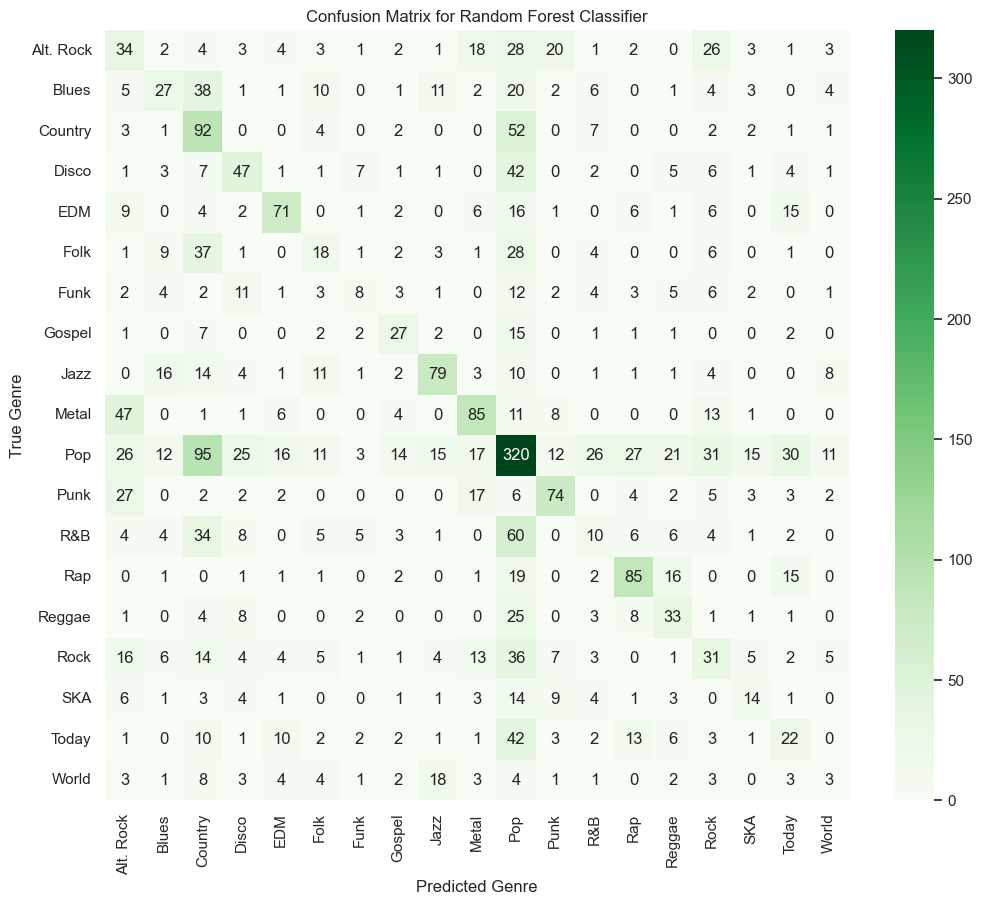

In [14]:
# Confusion Matrix for Random Forest Classifier

# Compute confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### b. Support Vector Machines (SVM)

In [15]:
# Initialize the SVM classifier with probability estimates
svm_clf = SVC(probability=True, random_state=42)

# Train the SVM model
svm_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_svm = svm_clf.predict(X_test_scaled)

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classifier Accuracy: {svm_accuracy:.4f}")

# Display classification report
print("\nClassification Report for SVM Classifier:\n")
print(
    classification_report(y_test, y_pred_svm, target_names=genre_encoder.classes_)
)

SVM Classifier Accuracy: 0.3240

Classification Report for SVM Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.17      0.19      0.18       156
       Blues       0.20      0.18      0.19       136
     Country       0.23      0.63      0.33       167
       Disco       0.34      0.32      0.33       130
         EDM       0.49      0.48      0.48       140
        Folk       0.13      0.11      0.12       112
        Funk       0.16      0.10      0.12        70
      Gospel       0.29      0.38      0.33        61
        Jazz       0.53      0.46      0.49       156
       Metal       0.49      0.47      0.48       177
         Pop       0.38      0.31      0.34       727
        Punk       0.54      0.42      0.47       149
         R&B       0.20      0.10      0.14       153
         Rap       0.49      0.58      0.54       144
      Reggae       0.35      0.44      0.39        87
        Rock       0.17      0.18      0.18       158
     

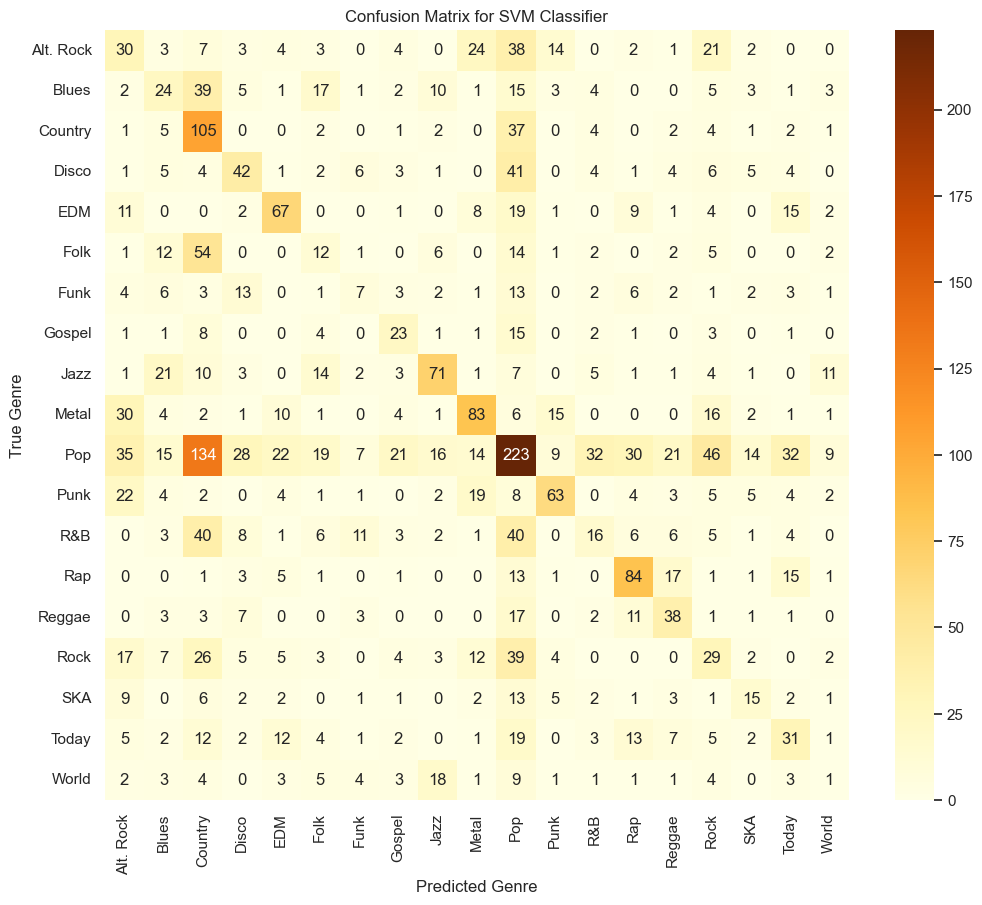

In [16]:
# Confusion Matrix for SVM Classifier

# Compute confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_svm,
    annot=True,
    fmt="d",
    cmap="YlOrBr",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for SVM Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### c. XGBoost Classifier

In [17]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(
    random_state=42, use_label_encoder=False, eval_metric="mlogloss"
)

# Train the XGBoost model
xgb_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test_scaled)

# Evaluate the XGBoost model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Classifier Accuracy: {xgb_accuracy:.4f}")

# Display classification report
print("\nClassification Report for XGBoost Classifier:\n")
print(classification_report(y_test, y_pred_xgb, target_names=genre_encoder.classes_))

XGBoost Classifier Accuracy: 0.3509

Classification Report for XGBoost Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.21      0.21      0.21       156
       Blues       0.31      0.15      0.21       136
     Country       0.24      0.40      0.30       167
       Disco       0.38      0.22      0.28       130
         EDM       0.57      0.45      0.50       140
        Folk       0.21      0.07      0.11       112
        Funk       0.29      0.14      0.19        70
      Gospel       0.46      0.28      0.35        61
        Jazz       0.65      0.37      0.47       156
       Metal       0.54      0.46      0.50       177
         Pop       0.36      0.60      0.45       727
        Punk       0.53      0.39      0.45       149
         R&B       0.15      0.08      0.11       153
         Rap       0.53      0.49      0.51       144
      Reggae       0.34      0.31      0.33        87
        Rock       0.14      0.13      0.13       1

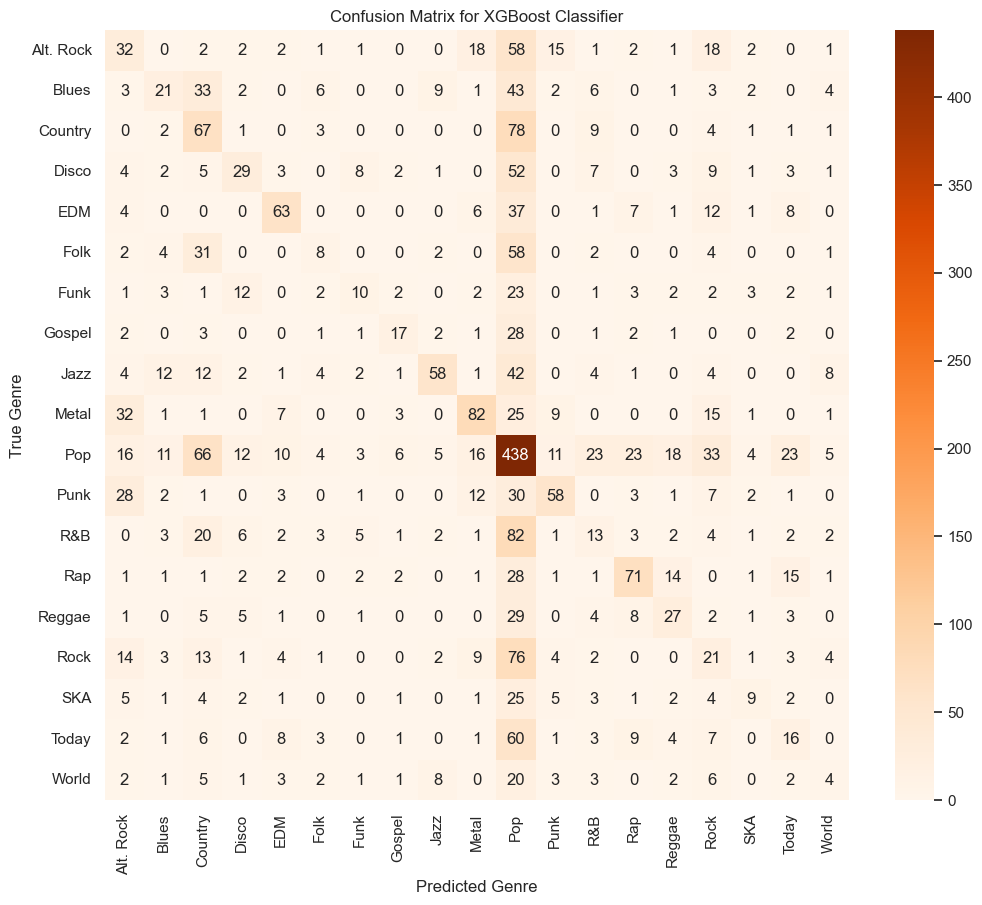

In [18]:
# Confusion Matrix for XGBoost Classifier

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_xgb,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for XGBoost Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### d. K-Nearest Neighbors (KNN)

In [19]:
# Initialize the K-Nearest Neighbors classifier
knn_clf = KNeighborsClassifier(n_neighbors=len(genre_encoder.classes_))

# Train the KNN model
knn_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_knn = knn_clf.predict(X_test_scaled)

# Evaluate the KNN model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"K-Nearest Neighbors Classifier Accuracy: {knn_accuracy:.4f}")

# Display classification report
print("\nClassification Report for K-Nearest Neighbors Classifier:\n")
print(
    classification_report(y_test, y_pred_knn, target_names=genre_encoder.classes_)
)

K-Nearest Neighbors Classifier Accuracy: 0.2531

Classification Report for K-Nearest Neighbors Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.14      0.19      0.16       156
       Blues       0.15      0.16      0.16       136
     Country       0.19      0.41      0.26       167
       Disco       0.23      0.33      0.27       130
         EDM       0.42      0.48      0.45       140
        Folk       0.14      0.19      0.16       112
        Funk       0.08      0.10      0.09        70
      Gospel       0.17      0.44      0.25        61
        Jazz       0.49      0.44      0.46       156
       Metal       0.43      0.36      0.39       177
         Pop       0.42      0.14      0.21       727
        Punk       0.47      0.38      0.42       149
         R&B       0.16      0.14      0.15       153
         Rap       0.48      0.51      0.49       144
      Reggae       0.27      0.40      0.32        87
        Rock       0.07    

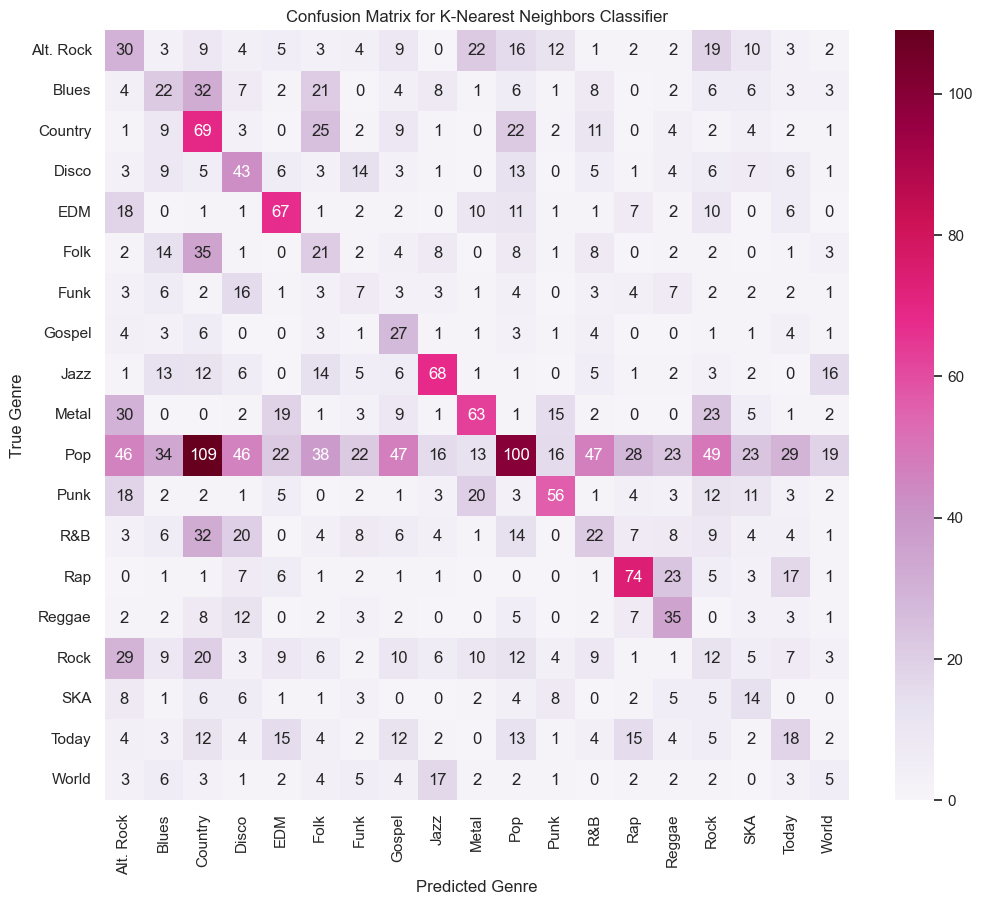

In [20]:
# Confusion Matrix for K-Nearest Neighbors Classifier

# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_knn,
    annot=True,
    fmt="d",
    cmap="PuRd",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for K-Nearest Neighbors Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### e. Extra Trees Classifier

In [21]:
# Initialize the Extra Trees Classifier
extra_trees_clf = ExtraTreesClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)

# Train the model
extra_trees_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred_extra_trees = extra_trees_clf.predict(X_test_scaled)

# Evaluate the model
extra_trees_accuracy = accuracy_score(y_test, y_pred_extra_trees)
print(f"Extra Trees Classifier Accuracy: {extra_trees_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Extra Trees Classifier:\n")
print(
    classification_report(
        y_test, y_pred_extra_trees, target_names=genre_encoder.classes_
    )
)

Extra Trees Classifier Accuracy: 0.3489

Classification Report for Extra Trees Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.18      0.17      0.18       156
       Blues       0.31      0.25      0.28       136
     Country       0.24      0.51      0.33       167
       Disco       0.36      0.42      0.38       130
         EDM       0.51      0.49      0.50       140
        Folk       0.15      0.12      0.13       112
        Funk       0.18      0.09      0.12        70
      Gospel       0.27      0.36      0.31        61
        Jazz       0.51      0.54      0.53       156
       Metal       0.49      0.54      0.51       177
         Pop       0.42      0.38      0.40       727
        Punk       0.48      0.51      0.49       149
         R&B       0.13      0.08      0.10       153
         Rap       0.51      0.58      0.54       144
      Reggae       0.30      0.37      0.33        87
        Rock       0.21      0.16      0.18

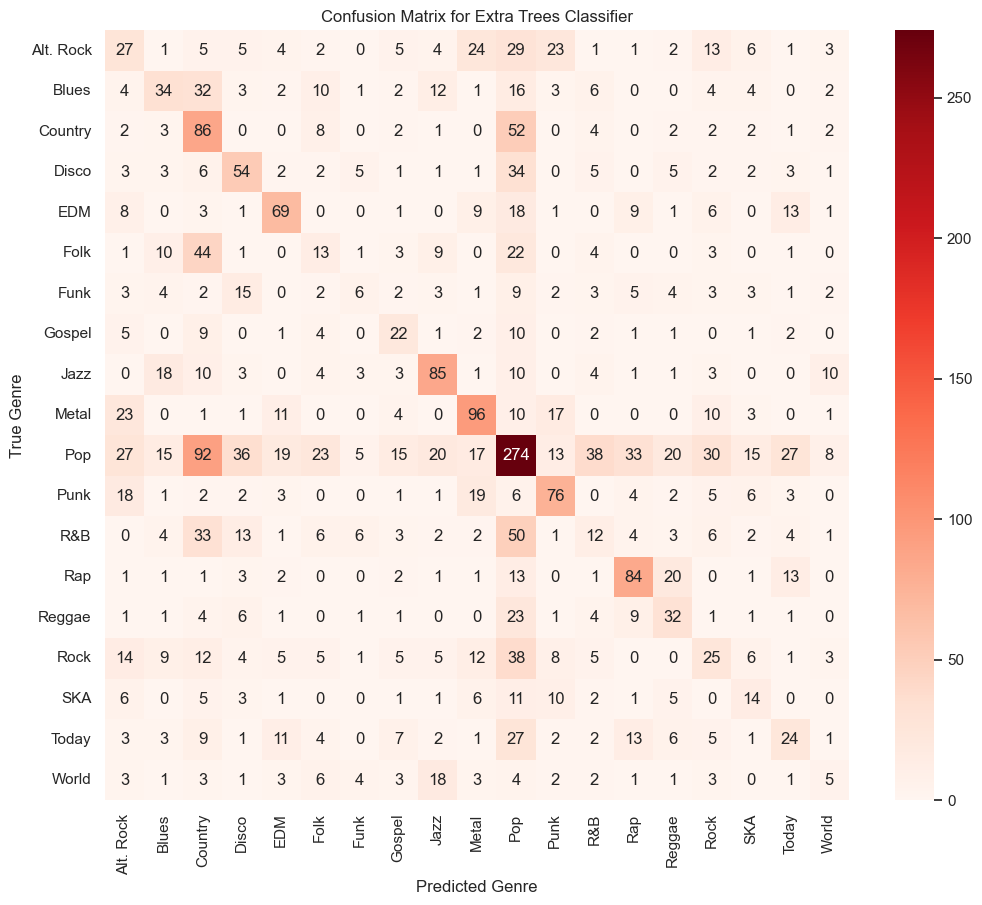

In [22]:
# Confusion Matrix for Extra Trees Classifier

# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_extra_trees)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_knn,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for Extra Trees Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### f. CatBoost Classifier

In [23]:
# Initialize the CatBoost Classifier
catboost_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
)

# Train the model
catboost_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred_catboost = catboost_clf.predict(X_test_scaled)

# Evaluate the model
catboost_accuracy = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Classifier Accuracy: {catboost_accuracy:.4f}")
print("\nClassification Report for CatBoost Classifier:\n")
print(
    classification_report(y_test, y_pred_catboost, target_names=genre_encoder.classes_)
)

CatBoost Classifier Accuracy: 0.3415

Classification Report for CatBoost Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.20      0.26      0.22       156
       Blues       0.35      0.21      0.26       136
     Country       0.22      0.65      0.33       167
       Disco       0.39      0.35      0.37       130
         EDM       0.58      0.40      0.47       140
        Folk       0.19      0.11      0.14       112
        Funk       0.22      0.11      0.15        70
      Gospel       0.30      0.48      0.36        61
        Jazz       0.57      0.36      0.44       156
       Metal       0.54      0.51      0.52       177
         Pop       0.42      0.39      0.41       727
        Punk       0.54      0.40      0.46       149
         R&B       0.19      0.07      0.10       153
         Rap       0.54      0.57      0.55       144
      Reggae       0.27      0.32      0.30        87
        Rock       0.18      0.23      0.21      

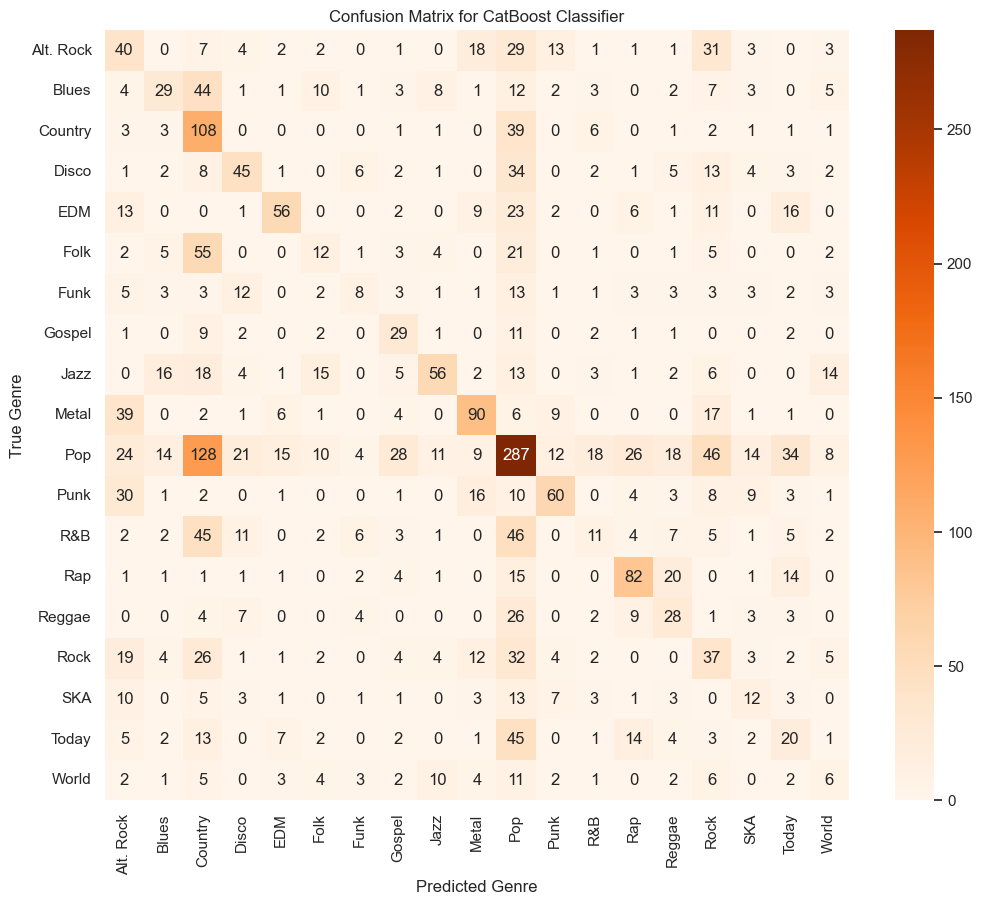

In [24]:
# Confusion Matrix
conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_catboost,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for CatBoost Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### g. Logistic Regression

In [25]:
# Initialize the Logistic Regression classifier
logreg_clf = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
)

# Train the model
logreg_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred_logreg = logreg_clf.predict(X_test_scaled)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")
print("\nClassification Report for Logistic Regression:\n")
print(classification_report(y_test, y_pred_logreg, target_names=genre_encoder.classes_))

Logistic Regression Accuracy: 0.2679

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

   Alt. Rock       0.20      0.19      0.19       156
       Blues       0.21      0.08      0.12       136
     Country       0.21      0.75      0.32       167
       Disco       0.24      0.47      0.32       130
         EDM       0.42      0.51      0.46       140
        Folk       0.16      0.14      0.15       112
        Funk       0.16      0.09      0.11        70
      Gospel       0.17      0.38      0.23        61
        Jazz       0.53      0.47      0.50       156
       Metal       0.48      0.54      0.51       177
         Pop       0.39      0.03      0.05       727
        Punk       0.49      0.44      0.46       149
         R&B       0.16      0.05      0.07       153
         Rap       0.51      0.51      0.51       144
      Reggae       0.28      0.38      0.32        87
        Rock       0.16      0.24      0.19      

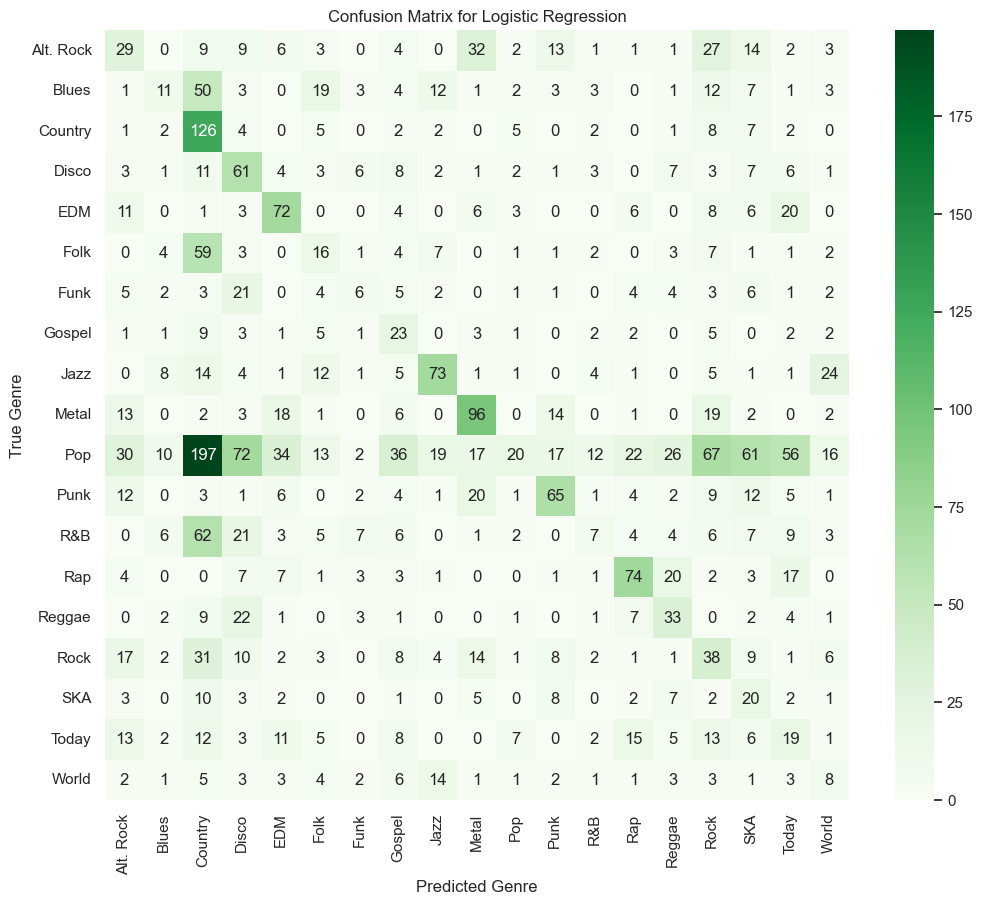

In [26]:
# Confusion Matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_logreg,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### h. Multi-Layer Perceptron

In [27]:
# Initialize the MLP Classifier
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42,
)

# Train the model
mlp_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred_mlp = mlp_clf.predict(X_test_scaled)

# Evaluate the model
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Classifier Accuracy: {mlp_accuracy:.4f}")
print("\nClassification Report for MLP Classifier:\n")
print(classification_report(y_test, y_pred_mlp, target_names=genre_encoder.classes_))

MLP Classifier Accuracy: 0.2864

Classification Report for MLP Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.16      0.15      0.15       156
       Blues       0.29      0.17      0.21       136
     Country       0.18      0.77      0.29       167
       Disco       0.38      0.21      0.27       130
         EDM       0.52      0.35      0.42       140
        Folk       0.14      0.12      0.13       112
        Funk       0.22      0.16      0.18        70
      Gospel       0.27      0.25      0.26        61
        Jazz       0.60      0.23      0.33       156
       Metal       0.50      0.39      0.44       177
         Pop       0.37      0.28      0.32       727
        Punk       0.52      0.40      0.45       149
         R&B       0.19      0.08      0.11       153
         Rap       0.50      0.60      0.54       144
      Reggae       0.31      0.38      0.34        87
        Rock       0.11      0.19      0.14       158
     

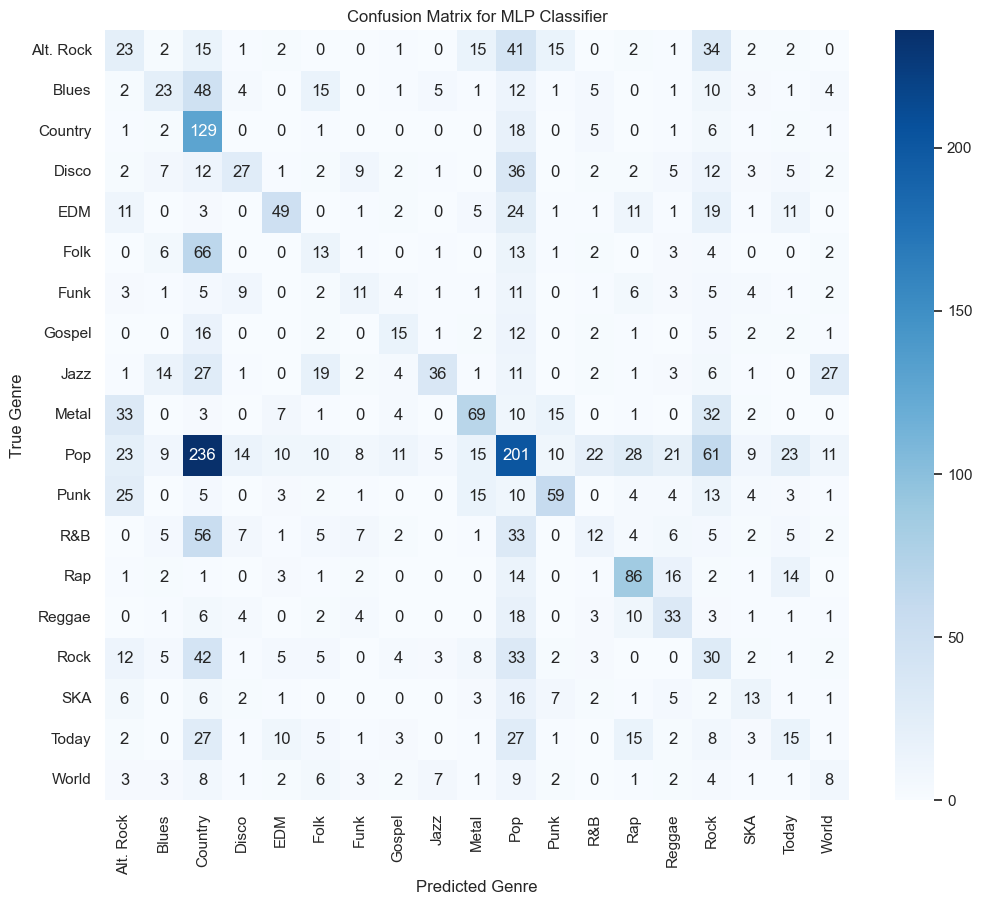

In [28]:
# Confusion Matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_mlp,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for MLP Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### i. Quadratic Discriminant Analysis

In [29]:
# Initialize the Quadratic Discriminant Analysis classifier
qda_clf = QuadraticDiscriminantAnalysis()

# Train the model
qda_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions
y_pred_qda = qda_clf.predict(X_test_scaled)

# Evaluate the model
qda_accuracy = accuracy_score(y_test, y_pred_qda)
print(f"Quadratic Discriminant Analysis Accuracy: {qda_accuracy:.4f}")
print("\nClassification Report for Quadratic Discriminant Analysis:\n")
print(
    classification_report(y_test, y_pred_qda, target_names=genre_encoder.classes_)
)

Quadratic Discriminant Analysis Accuracy: 0.2524

Classification Report for Quadratic Discriminant Analysis:

              precision    recall  f1-score   support

   Alt. Rock       0.23      0.10      0.14       156
       Blues       0.29      0.12      0.17       136
     Country       0.24      0.59      0.34       167
       Disco       0.33      0.29      0.31       130
         EDM       0.43      0.52      0.47       140
        Folk       0.21      0.10      0.13       112
        Funk       0.18      0.13      0.15        70
      Gospel       0.08      0.51      0.14        61
        Jazz       0.54      0.43      0.48       156
       Metal       0.46      0.44      0.45       177
         Pop       0.39      0.03      0.06       727
        Punk       0.48      0.44      0.46       149
         R&B       0.16      0.12      0.14       153
         Rap       0.50      0.49      0.50       144
      Reggae       0.17      0.60      0.26        87
        Rock       0.14  

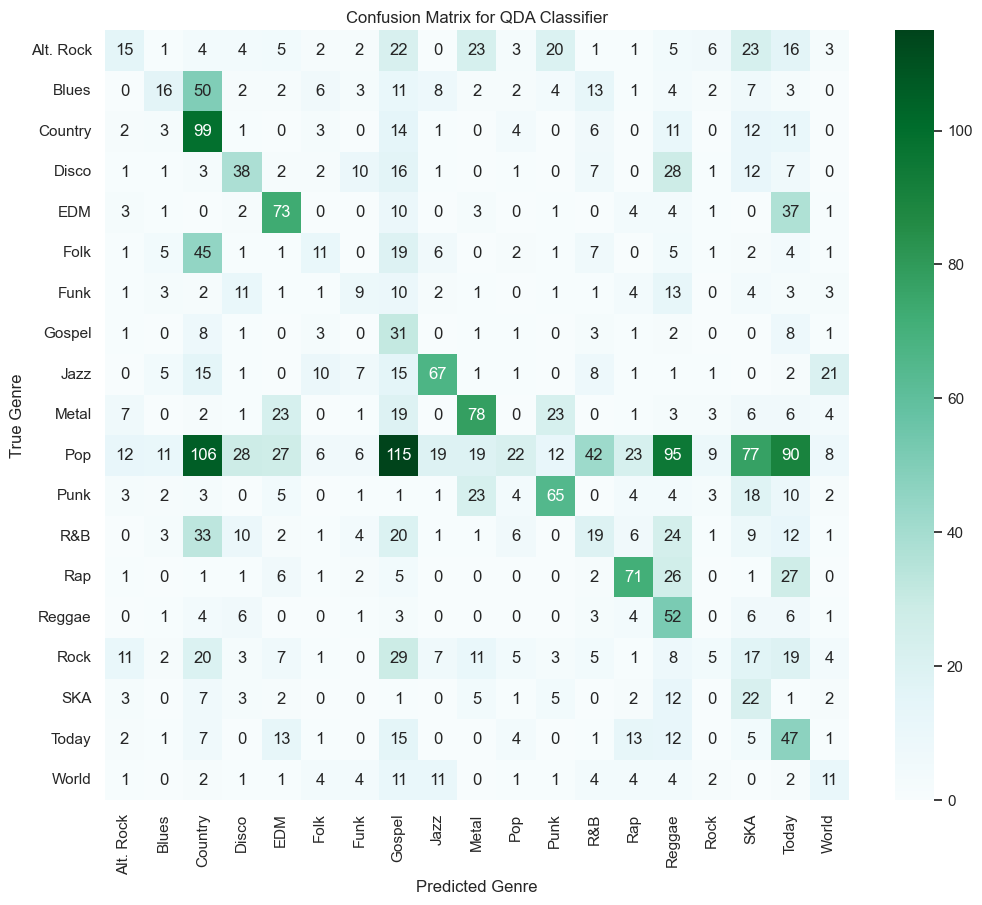

In [30]:
# Confusion Matrix
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda)
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_qda,
    annot=True,
    fmt="d",
    cmap="BuGn",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for QDA Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 9. Hyperparameter Tuning

In [31]:
NUMBER_OF_JOBS = -1

### a. Hyperparameter Tuning for Random Forest

In [32]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=NUMBER_OF_JOBS,
    verbose=2,
    scoring="accuracy",
)

# Fit GridSearchCV on the training data
grid_search_rf.fit(X_train_scaled, y_train_resampled)

# Best parameters found
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Best estimator
best_rf = grid_search_rf.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [33]:
# Make predictions with the best Random Forest model
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the best Random Forest model
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
print(f"Tuned Random Forest Classifier Accuracy: {best_rf_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Tuned Random Forest Classifier:\n")
print(
    classification_report(y_test, y_pred_best_rf, target_names=genre_encoder.classes_)
)

Tuned Random Forest Classifier Accuracy: 0.3731

Classification Report for Tuned Random Forest Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.19      0.24      0.22       156
       Blues       0.33      0.22      0.26       136
     Country       0.25      0.51      0.34       167
       Disco       0.40      0.36      0.38       130
         EDM       0.55      0.49      0.52       140
        Folk       0.25      0.15      0.19       112
        Funk       0.26      0.10      0.14        70
      Gospel       0.40      0.44      0.42        61
        Jazz       0.61      0.50      0.55       156
       Metal       0.52      0.49      0.51       177
         Pop       0.42      0.49      0.45       727
        Punk       0.51      0.46      0.48       149
         R&B       0.16      0.08      0.10       153
         Rap       0.54      0.58      0.56       144
      Reggae       0.33      0.39      0.36        87
        Rock       0.21    

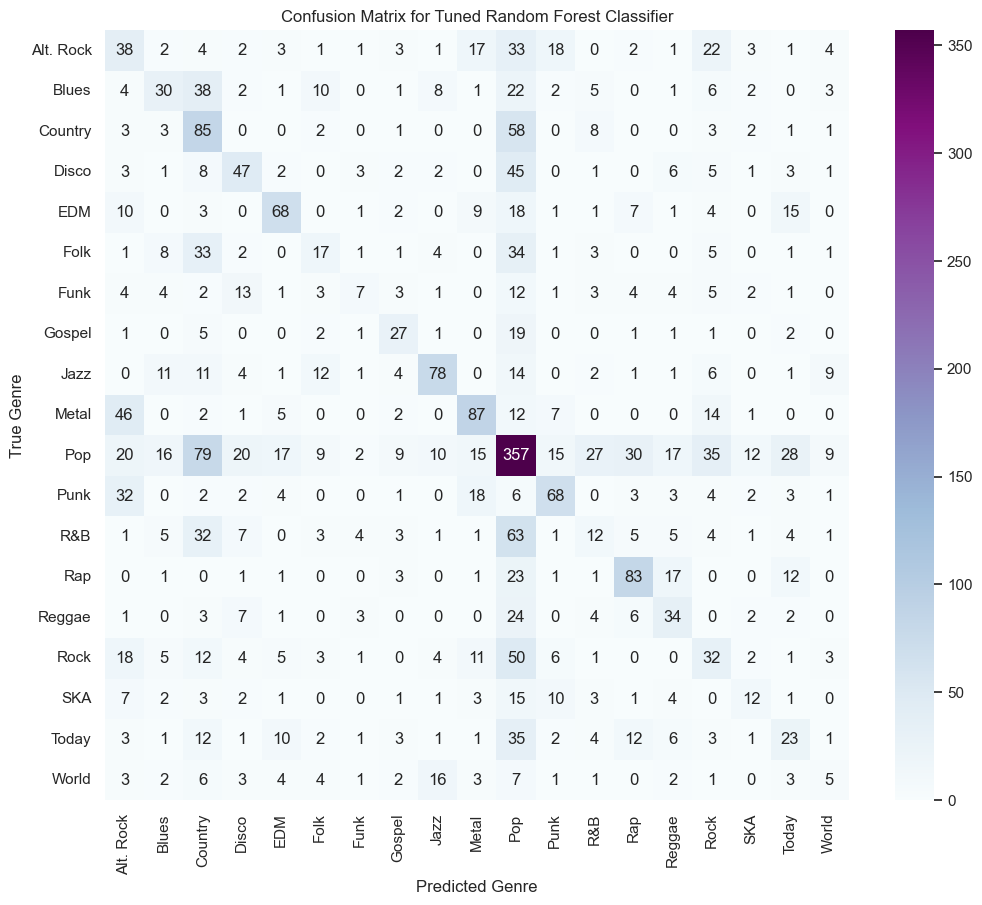

In [34]:
# Confusion Matrix for Tuned Random Forest Classifier

# Compute confusion matrix
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_best_rf,
    annot=True,
    fmt="d",
    cmap="BuPu",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for Tuned Random Forest Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### b. Hyperparameter Tuning for SVM

*Nothing to tune for SVM*

### c. Hyperparameter Tuning for XGBoost

In [35]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=NUMBER_OF_JOBS,
    verbose=2,
    scoring="accuracy",
)

# Fit GridSearchCV on the training data
grid_search_xgb.fit(X_train_scaled, y_train_resampled)

# Best parameters found
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Best estimator
best_xgb = grid_search_xgb.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters for XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


In [36]:
# Make predictions with the best XGBoost model
y_pred_best_xgb = best_xgb.predict(X_test_scaled)

# Evaluate the best XGBoost model
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
print(f"Tuned XGBoost Classifier Accuracy: {best_xgb_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Tuned XGBoost Classifier:\n")
print(
    classification_report(y_test, y_pred_best_xgb, target_names=genre_encoder.classes_)
)

Tuned XGBoost Classifier Accuracy: 0.3509

Classification Report for Tuned XGBoost Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.21      0.19      0.20       156
       Blues       0.35      0.18      0.24       136
     Country       0.22      0.37      0.28       167
       Disco       0.44      0.27      0.33       130
         EDM       0.61      0.47      0.53       140
        Folk       0.22      0.09      0.13       112
        Funk       0.30      0.11      0.16        70
      Gospel       0.48      0.34      0.40        61
        Jazz       0.64      0.35      0.45       156
       Metal       0.53      0.41      0.46       177
         Pop       0.35      0.59      0.44       727
        Punk       0.54      0.40      0.46       149
         R&B       0.18      0.09      0.12       153
         Rap       0.53      0.50      0.51       144
      Reggae       0.36      0.34      0.35        87
        Rock       0.15      0.17      

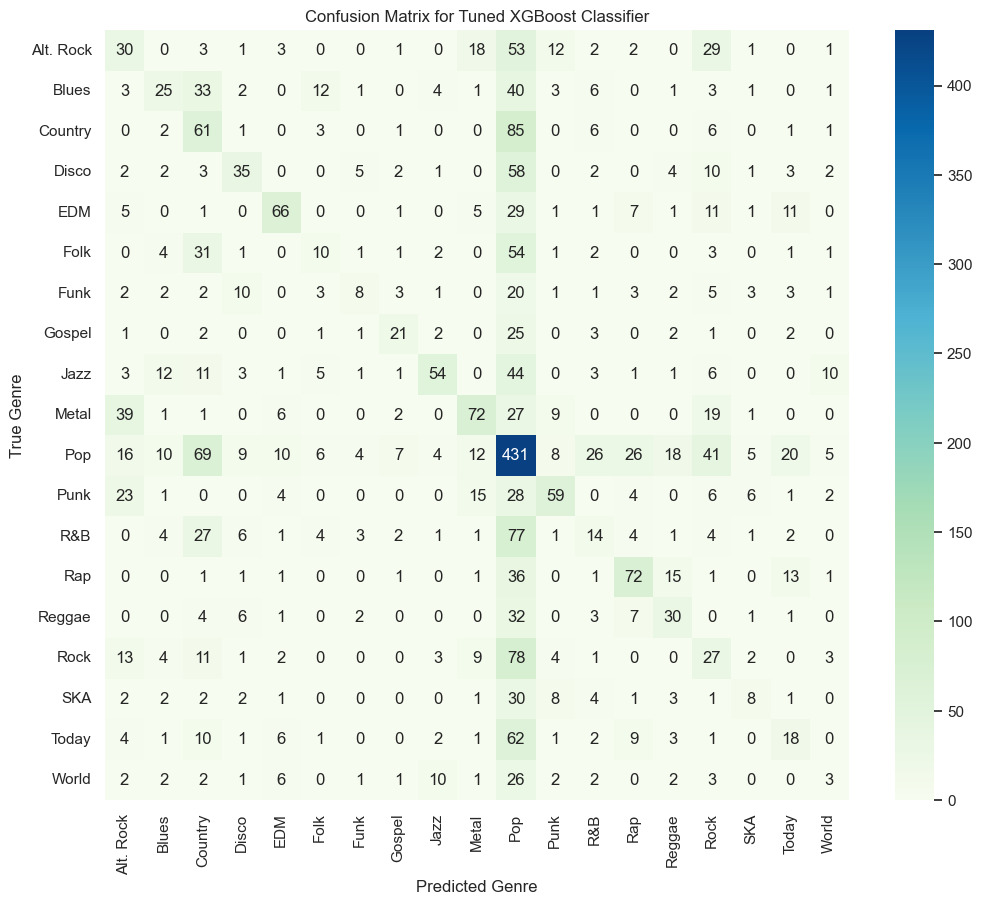

In [37]:
# Confusion Matrix for Tuned XGBoost Classifier

# Compute confusion matrix
conf_matrix_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_best_xgb,
    annot=True,
    fmt="d",
    cmap="GnBu",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for Tuned XGBoost Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### d. Hyperparameter Tuning for KNN

*Nothing to tune for KNN*

### e. Hyperparameter Tuning for Extra Trees

In [38]:
# Define the parameter grid for Extra Trees
param_grid_extra_trees = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20, 30],
}

# Initialize GridSearchCV for Extra Trees
grid_search_extra_trees = GridSearchCV(
    estimator=extra_trees_clf,
    param_grid=param_grid_extra_trees,
    cv=3,
    n_jobs=NUMBER_OF_JOBS,
    verbose=2,
    scoring="accuracy",
)

# Fit GridSearchCV on the training data
grid_search_extra_trees.fit(X_train_scaled, y_train_resampled)

# Best parameters found
print("Best Parameters for Extra Trees:", grid_search_extra_trees.best_params_)

# Best estimator
best_extra_trees = grid_search_extra_trees.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters for Extra Trees: {'max_depth': 30, 'n_estimators': 200}


In [39]:
# Make predictions with the best Extra Trees model
y_pred_best_extra_trees = best_extra_trees.predict(X_test_scaled)

# Evaluate the best Extra Trees model
best_extra_trees_accuracy = accuracy_score(y_test, y_pred_best_extra_trees)
print(f"Tuned Extra Trees Classifier Accuracy: {best_extra_trees_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Tuned Extra Trees Classifier:\n")
print(
    classification_report(
        y_test, y_pred_best_extra_trees, target_names=genre_encoder.classes_
    )
)

Tuned Extra Trees Classifier Accuracy: 0.3489

Classification Report for Tuned Extra Trees Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.16      0.15      0.15       156
       Blues       0.28      0.21      0.24       136
     Country       0.23      0.50      0.32       167
       Disco       0.34      0.38      0.36       130
         EDM       0.53      0.51      0.52       140
        Folk       0.14      0.12      0.13       112
        Funk       0.23      0.10      0.14        70
      Gospel       0.26      0.34      0.30        61
        Jazz       0.53      0.54      0.54       156
       Metal       0.48      0.54      0.51       177
         Pop       0.42      0.39      0.40       727
        Punk       0.48      0.53      0.50       149
         R&B       0.16      0.08      0.11       153
         Rap       0.49      0.57      0.53       144
      Reggae       0.35      0.44      0.39        87
        Rock       0.18      0.

<Axes: >

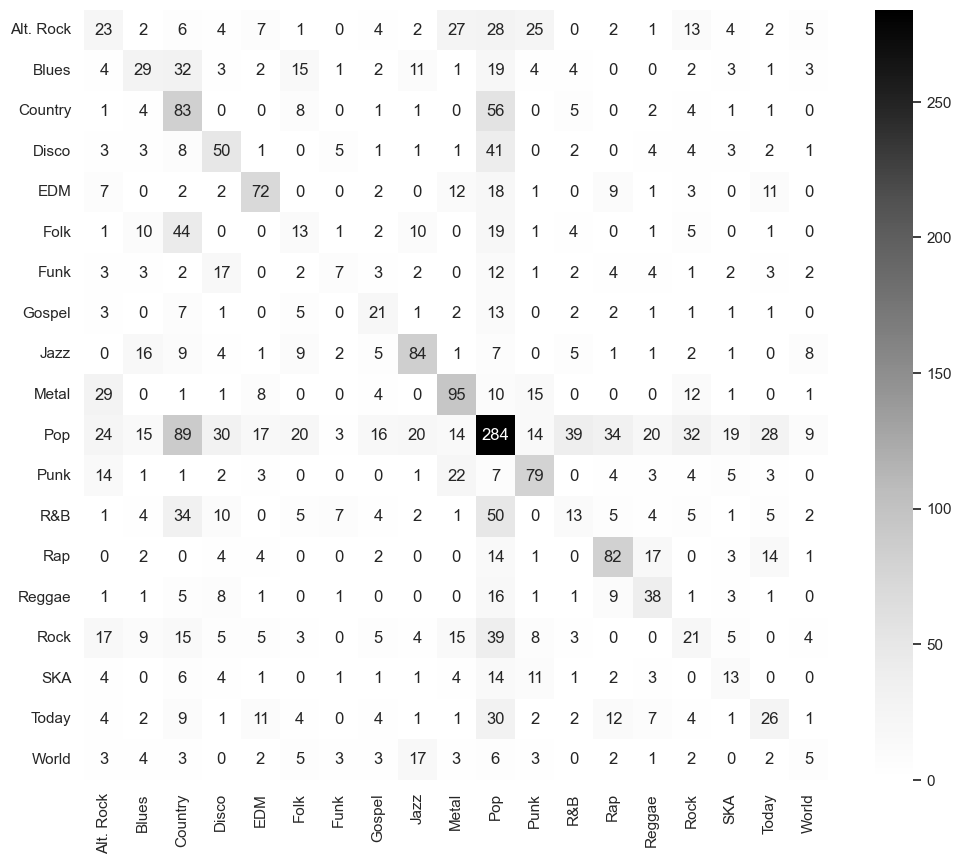

In [40]:
# Confusion Matrix for Tuned Extra Trees Classifier

# Compute confusion matrix
conf_matrix_best_extra_trees = confusion_matrix(y_test, y_pred_best_extra_trees)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_best_extra_trees,
    annot=True,
    fmt="d",
    cmap="Greys",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)

### f. Hyperparameter Tuning for CatBoost

In [41]:
# Define the parameter grid for CatBoost
param_grid_catboost = {
    "iterations": [100, 200],
    "learning_rate": [0.01, 0.1],
}

# Initialize GridSearchCV for CatBoost
grid_search_catboost = GridSearchCV(
    estimator=catboost_clf,
    param_grid=param_grid_catboost,
    cv=3,
    n_jobs=NUMBER_OF_JOBS,
    verbose=2,
    scoring="accuracy",
)

# Fit GridSearchCV on the training data
grid_search_catboost.fit(X_train_scaled, y_train_resampled)

# Best parameters found
print("Best Parameters for CatBoost:", grid_search_catboost.best_params_)

# Best estimator
best_catboost = grid_search_catboost.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters for CatBoost: {'iterations': 200, 'learning_rate': 0.1}


In [42]:
# Make predictions with the best CatBoost model
y_pred_best_catboost = best_catboost.predict(X_test_scaled)

# Evaluate the best CatBoost model
best_catboost_accuracy = accuracy_score(y_test, y_pred_best_catboost)
print(f"Tuned CatBoost Classifier Accuracy: {best_catboost_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Tuned CatBoost Classifier:\n")
print(
    classification_report(
        y_test, y_pred_best_catboost, target_names=genre_encoder.classes_
    )
)

Tuned CatBoost Classifier Accuracy: 0.3519

Classification Report for Tuned CatBoost Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.20      0.22      0.21       156
       Blues       0.38      0.22      0.28       136
     Country       0.23      0.62      0.34       167
       Disco       0.40      0.29      0.34       130
         EDM       0.59      0.44      0.50       140
        Folk       0.23      0.12      0.16       112
        Funk       0.19      0.10      0.13        70
      Gospel       0.33      0.44      0.38        61
        Jazz       0.61      0.33      0.43       156
       Metal       0.56      0.50      0.53       177
         Pop       0.40      0.48      0.43       727
        Punk       0.52      0.41      0.46       149
         R&B       0.17      0.06      0.09       153
         Rap       0.52      0.53      0.53       144
      Reggae       0.31      0.33      0.32        87
        Rock       0.18      0.21    

<Axes: >

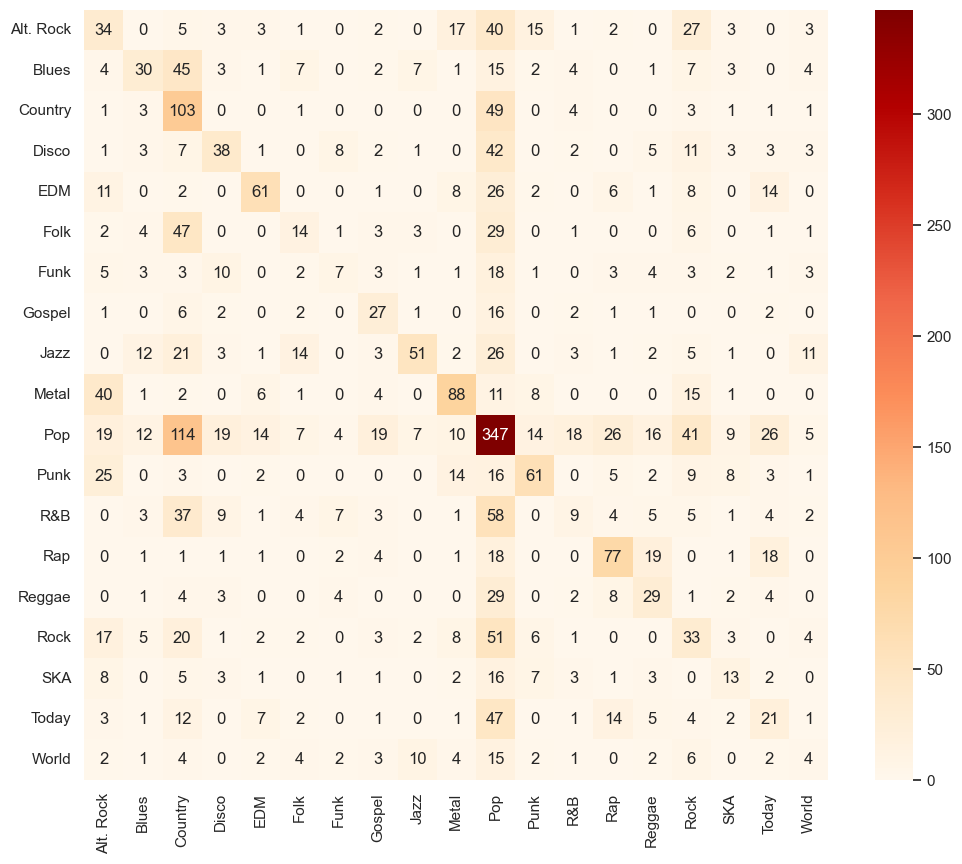

In [43]:
# Confusion Matrix for Tuned CatBoost Classifier

conf_matrix_best_catboost = confusion_matrix(y_test, y_pred_best_catboost)

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_best_catboost,
    annot=True,
    fmt="d",
    cmap="OrRd",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)

### g. Hyperparameter Tuning for Logistic Regression

*Nothing to tune for Logistic Regression*


### h. Hyperparameter Tuning for MLP

In [44]:
# Define the parameter grid for MLP
param_grid_mlp = {
    "hidden_layer_sizes": [(50,), (100,), (150,)],
    "activation": ["relu", "tanh"],
}

# Initialize GridSearchCV for MLP
grid_search_mlp = GridSearchCV(
    estimator=mlp_clf,
    param_grid=param_grid_mlp,
    cv=3,
    n_jobs=NUMBER_OF_JOBS,
    verbose=2,
    scoring="accuracy",
)

# Fit GridSearchCV on the training data
grid_search_mlp.fit(X_train_scaled, y_train_resampled)

# Best parameters found
print("Best Parameters for MLP:", grid_search_mlp.best_params_)

# Best estimator
best_mlp = grid_search_mlp.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters for MLP: {'activation': 'tanh', 'hidden_layer_sizes': (150,)}


In [45]:
# Make predictions with the best MLP model
y_pred_best_mlp = best_mlp.predict(X_test_scaled)

# Evaluate the best MLP model
best_mlp_accuracy = accuracy_score(y_test, y_pred_best_mlp)
print(f"Tuned MLP Classifier Accuracy: {best_mlp_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Tuned MLP Classifier:\n")
print(
    classification_report(y_test, y_pred_best_mlp, target_names=genre_encoder.classes_)
)

Tuned MLP Classifier Accuracy: 0.3018

Classification Report for Tuned MLP Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.16      0.24      0.19       156
       Blues       0.22      0.13      0.17       136
     Country       0.20      0.63      0.30       167
       Disco       0.35      0.25      0.29       130
         EDM       0.50      0.44      0.47       140
        Folk       0.19      0.13      0.16       112
        Funk       0.09      0.06      0.07        70
      Gospel       0.28      0.33      0.30        61
        Jazz       0.58      0.36      0.44       156
       Metal       0.52      0.30      0.38       177
         Pop       0.39      0.36      0.37       727
        Punk       0.46      0.37      0.41       149
         R&B       0.18      0.09      0.12       153
         Rap       0.48      0.49      0.48       144
      Reggae       0.30      0.30      0.30        87
        Rock       0.15      0.15      0.15    

<Axes: >

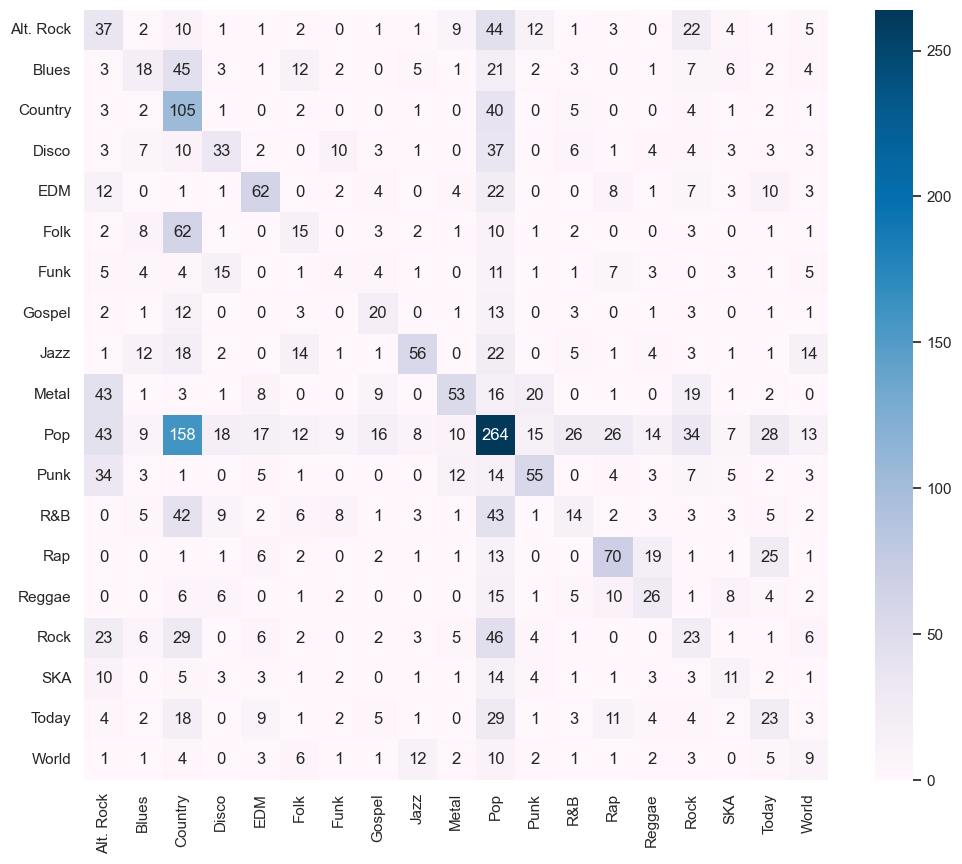

In [46]:
# Confusion Matrix for Tuned MLP Classifier

conf_matrix_best_mlp = confusion_matrix(y_test, y_pred_best_mlp)

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_best_mlp,
    annot=True,
    fmt="d",
    cmap="PuBu",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)

### i. Hyperparameter Tuning for QDA

*Nothing to tune for QDA*

## 10. Ensemble Methods: Voting Classifier

Combine multiple models to leverage their strengths and improve overall performance. The Voting Classifier now includes Random Forest, SVM, XGBoost, and KNN.

In [47]:
# Initialize the best models
models_ensemble = {
    "Random Forest": best_rf,
    "SVM": svm_clf,
    "XGBoost": best_xgb,
    "KNN": knn_clf,
    "Extra Trees": best_extra_trees,
    "Logistic Regression": logreg_clf,
    "CatBoost": best_catboost,
    "MLP": best_mlp,
    "QDA": qda_clf,
}

# Initialize Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ("rf", models_ensemble["Random Forest"]),
        ("svm", models_ensemble["SVM"]),
        ("xgb", models_ensemble["XGBoost"]),
        ("knn", models_ensemble["KNN"]),
        ("extra_trees", models_ensemble["Extra Trees"]),
        ("logreg", models_ensemble["Logistic Regression"]),
        ("catboost", models_ensemble["CatBoost"]),
        ("mlp", models_ensemble["MLP"]),
        ("qda", models_ensemble["QDA"]),
    ],
    voting="soft",
)  # 'soft' voting uses predicted class probabilities

# Train the Voting Classifier
voting_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluate the Voting Classifier
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Voting Classifier:\n")
print(
    classification_report(y_test, y_pred_voting, target_names=genre_encoder.classes_)
)

Voting Classifier Accuracy: 0.3600

Classification Report for Voting Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.20      0.19      0.20       156
       Blues       0.31      0.18      0.23       136
     Country       0.24      0.64      0.35       167
       Disco       0.38      0.35      0.36       130
         EDM       0.58      0.54      0.56       140
        Folk       0.25      0.13      0.17       112
        Funk       0.16      0.07      0.10        70
      Gospel       0.28      0.41      0.34        61
        Jazz       0.57      0.50      0.53       156
       Metal       0.51      0.47      0.49       177
         Pop       0.42      0.44      0.43       727
        Punk       0.52      0.45      0.48       149
         R&B       0.15      0.06      0.08       153
         Rap       0.50      0.55      0.52       144
      Reggae       0.33      0.41      0.37        87
        Rock       0.18      0.16      0.17       158

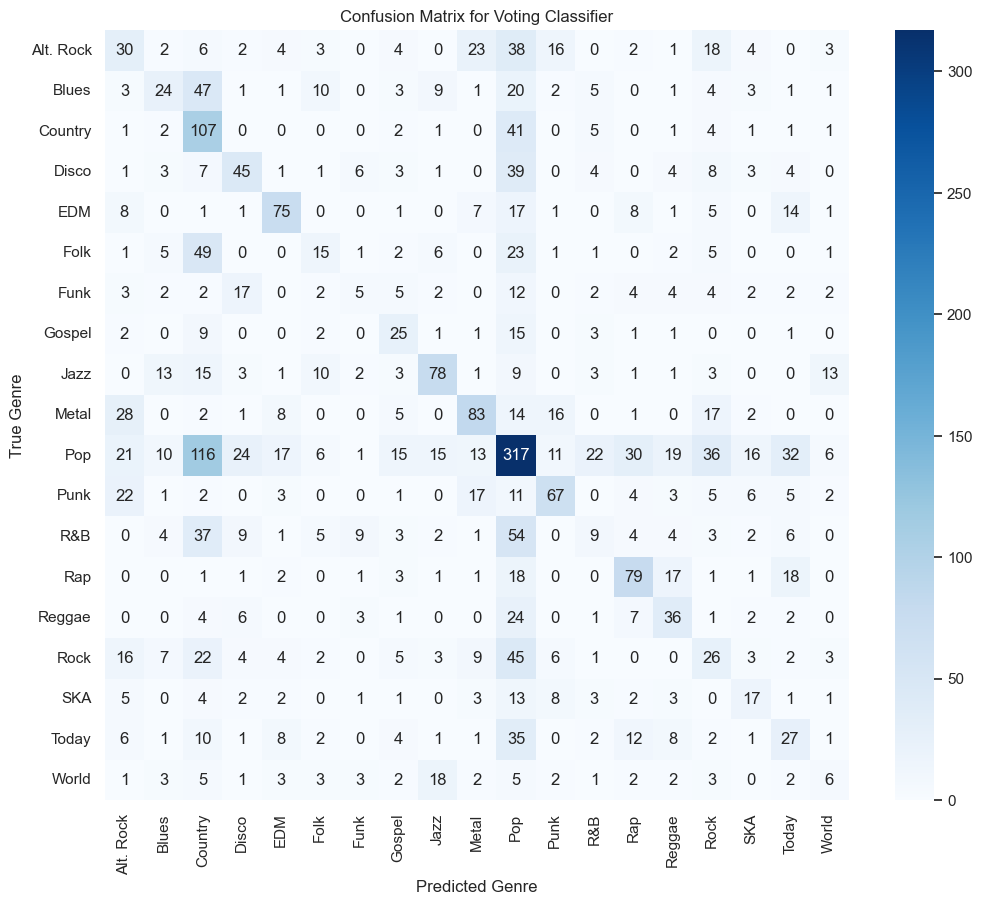

In [48]:
# Confusion Matrix for Voting Classifier

# Compute confusion matrix
conf_matrix_voting = confusion_matrix(y_test, y_pred_voting)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_voting,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=genre_encoder.classes_,
    yticklabels=genre_encoder.classes_,
)
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 11. Comparative Analysis of Models

Compare all developed models to identify the best-performing approach.

In [49]:
# Compile accuracy scores
model_names = [
    "DummyClassifier",
    "Random Forest",
    "SVM",
    "XGBoost",
    "KNN",
    "Extra Trees",
    "Logistic Regression",
    "CatBoost",
    "MLP",
    "QDA",
    "Voting Classifier",
]
accuracies = [
    dummy_accuracy,
    best_rf_accuracy,
    svm_accuracy,
    best_xgb_accuracy,
    knn_accuracy,
    best_extra_trees_accuracy,
    logreg_accuracy,
    best_catboost_accuracy,
    best_mlp_accuracy,
    qda_accuracy,
    voting_accuracy,
]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({"Model": model_names, "Accuracy": accuracies})

print(comparison_df)

                  Model  Accuracy
0       DummyClassifier  0.063529
1         Random Forest  0.373109
2                   SVM  0.324034
3               XGBoost  0.350924
4                   KNN  0.253109
5           Extra Trees  0.348908
6   Logistic Regression  0.267899
7              CatBoost  0.351933
8                   MLP  0.301849
9                   QDA  0.252437
10    Voting Classifier  0.360000


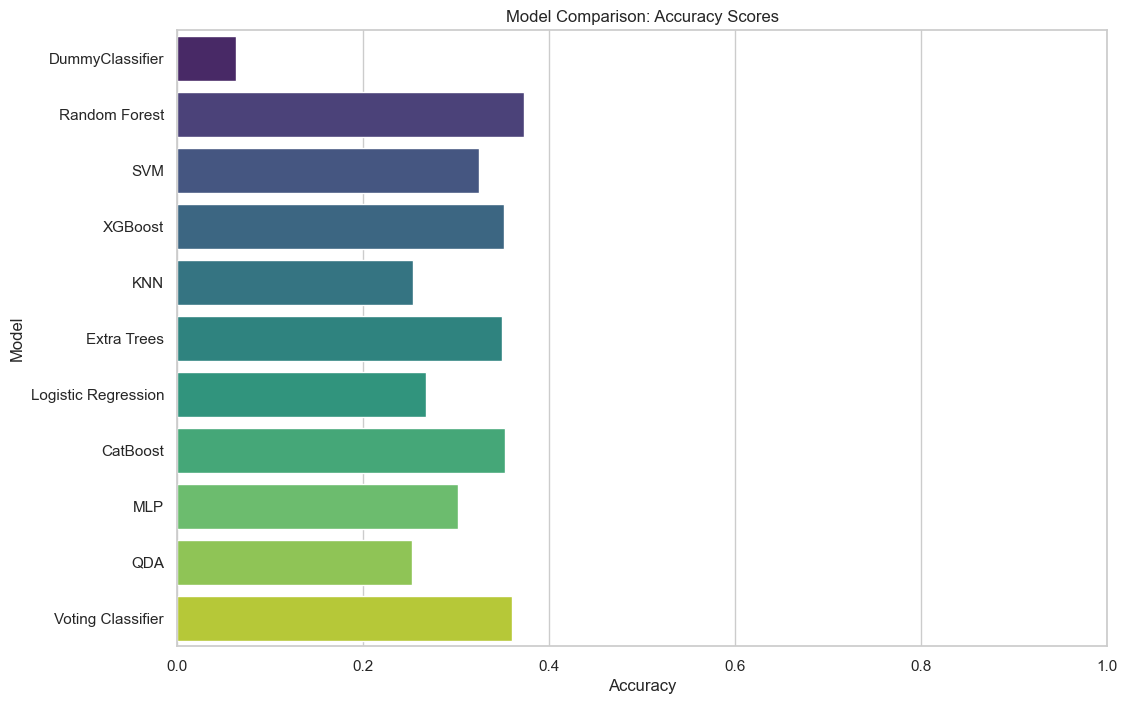

In [50]:
# Visualization of Model Accuracies
plt.figure(figsize=(12, 8))
sns.barplot(x="Accuracy", y="Model", data=comparison_df, palette="viridis")
plt.title("Model Comparison: Accuracy Scores")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.show()

## 12. Further Post-Evaluation

To gain deeper insights into model performance and identify areas for improvement, we conduct additional evaluation steps.

### a. Cross-Validation Performance

Assess the consistency of model performance across different data splits using cross-validation.

In [51]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models to evaluate
models_cv = {
    "Random Forest": best_rf,
    "SVM": svm_clf,
    "XGBoost": best_xgb,
    "KNN": knn_clf,
    "Extra Trees": best_extra_trees,
    "Logistic Regression": logreg_clf,
    "CatBoost": best_catboost,
    "MLP": best_mlp,
    "QDA": qda_clf,
    "Voting Classifier": voting_clf,
}

# Perform cross-validation
cv_results = {}
for model_name, model in models_cv.items():
    scores = cross_val_score(
        model, X_train_scaled, y_train_resampled, cv=skf, scoring="accuracy", n_jobs=-1
    )
    cv_results[model_name] = scores
    print(
        f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}"
    )

Random Forest Cross-Validation Accuracy: 0.7851 ± 0.0072
SVM Cross-Validation Accuracy: 0.5107 ± 0.0099
XGBoost Cross-Validation Accuracy: 0.7774 ± 0.0069
KNN Cross-Validation Accuracy: 0.4925 ± 0.0082
Extra Trees Cross-Validation Accuracy: 0.7626 ± 0.0075
Logistic Regression Cross-Validation Accuracy: 0.3912 ± 0.0109
CatBoost Cross-Validation Accuracy: 0.5424 ± 0.0097
MLP Cross-Validation Accuracy: 0.5241 ± 0.0092
QDA Cross-Validation Accuracy: 0.3819 ± 0.0084
Voting Classifier Cross-Validation Accuracy: 0.7041 ± 0.0102


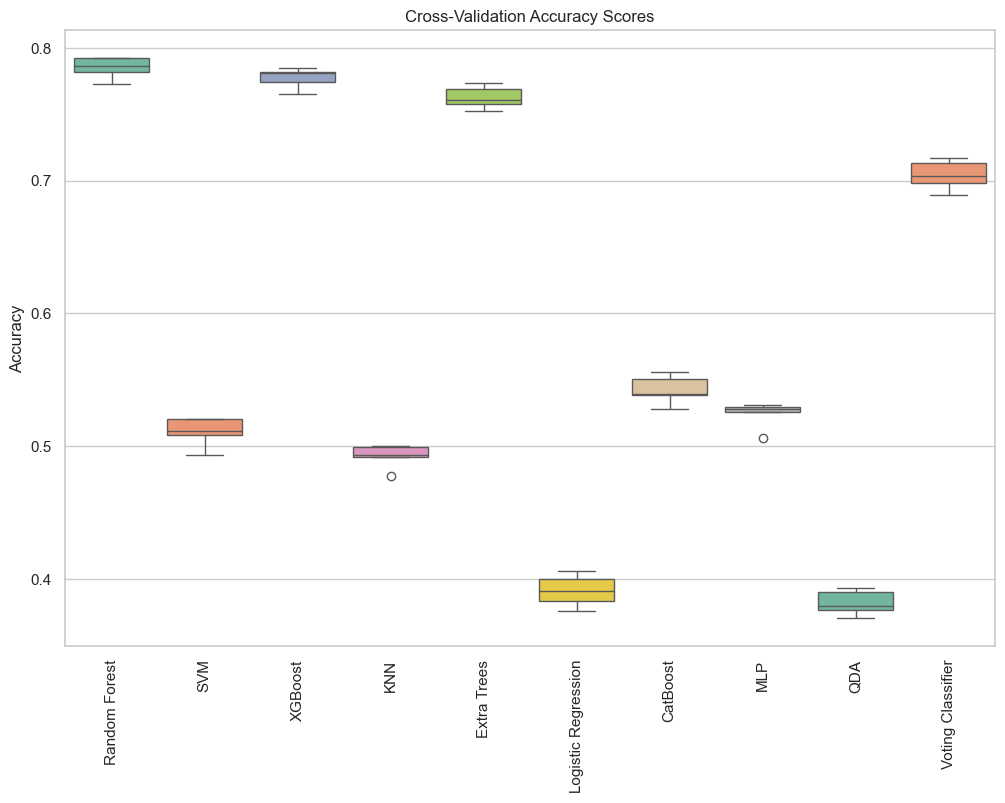

In [55]:
# Visualization of Cross-Validation Results
cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 8))
sns.boxplot(data=cv_df, palette="Set2")
plt.title("Cross-Validation Accuracy Scores")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)
plt.show()

### b. Feature Importance Analysis

Understand which features contribute most significantly to each model's predictions.

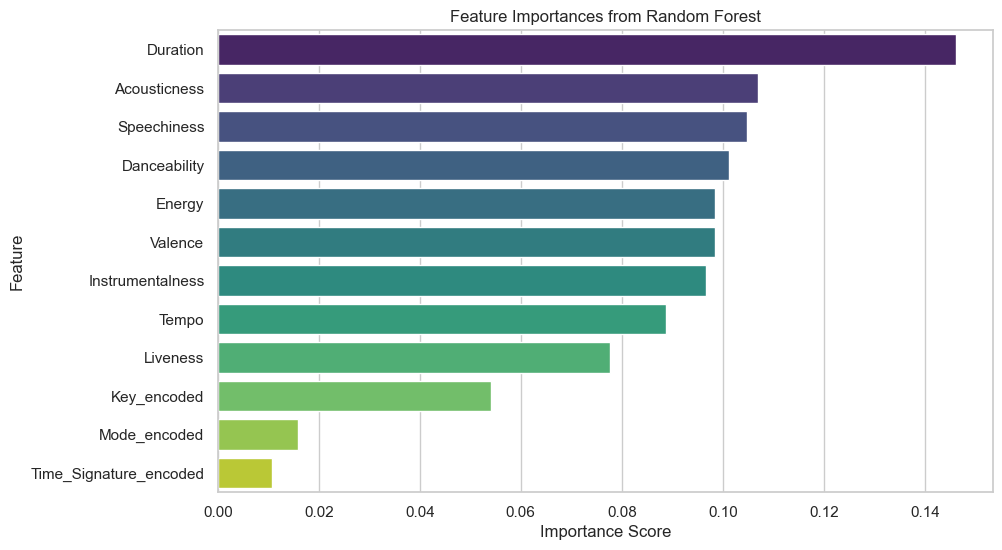

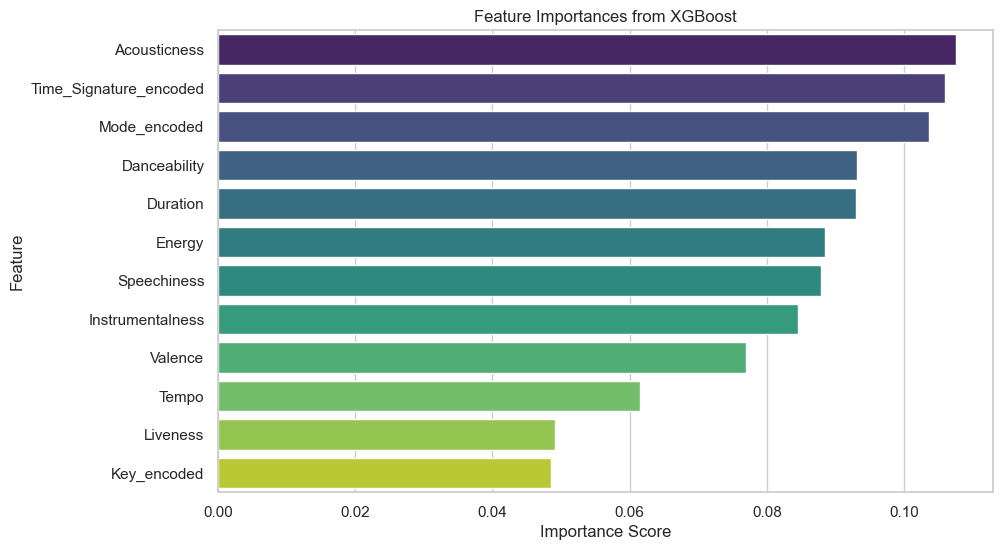

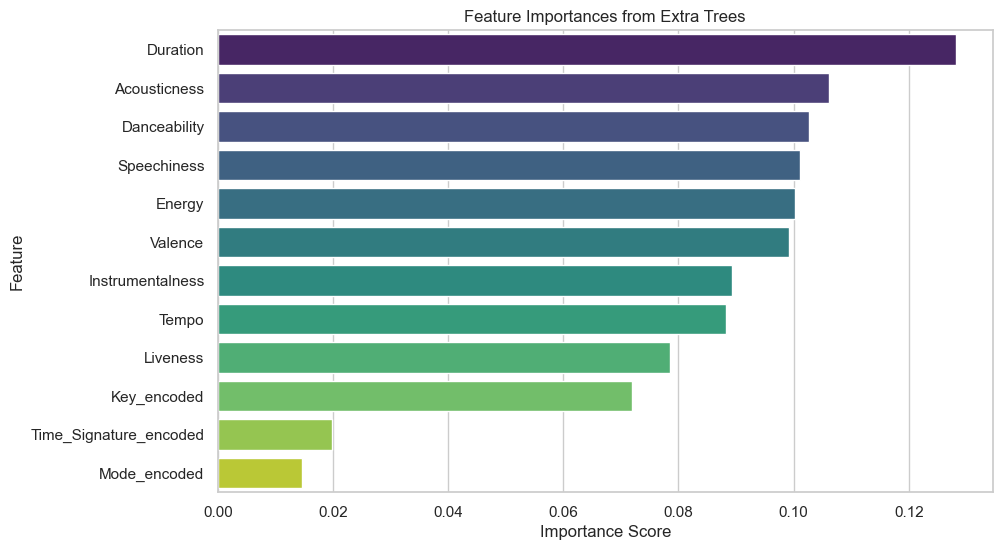

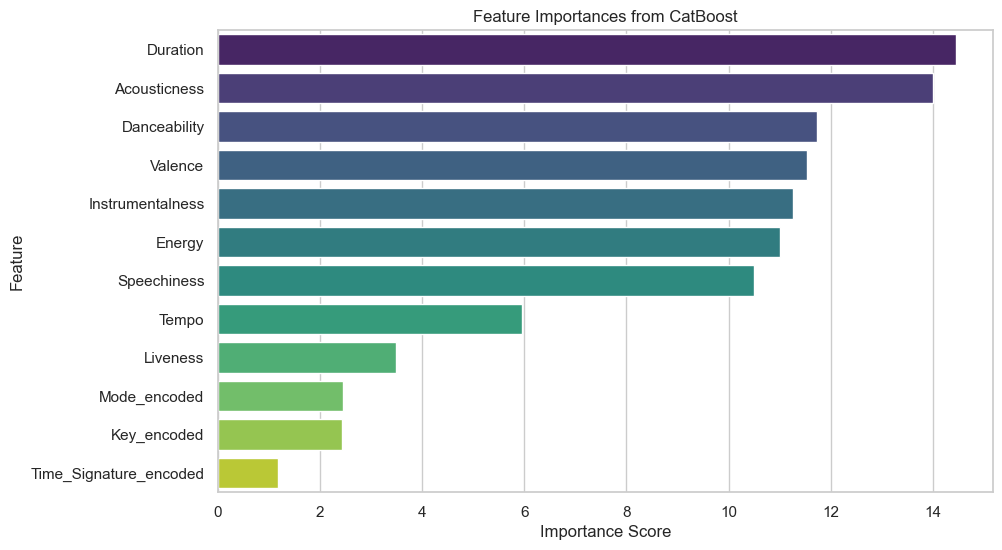

In [53]:
# Feature Importance for each model
models_cv = {
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "Extra Trees": best_extra_trees,
    "CatBoost": best_catboost,
}

for model_name, model in models_cv.items():
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=feature_columns).sort_values(
        ascending=False
    )
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=feature_importances, y=feature_importances.index, palette="viridis"
    )
    plt.title(f"Feature Importances from {model_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()
